# Least Squares problem solutions with different algorithms


## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as las
import torch
import tensorflow as tf

## Linear regression definition
We have a set of measures $X=[x_1, x_2, x_n]$ and the output $\hat y$, we would like to construct a linear model:
$\hat y = b_0 + \sum_{j=1}^n x_j b_j$

To find $b$, we solve a least squares problem. In matrix form we have $ X^T b =  \hat y$.



## Example in the book "Azzalini A., Scarpa B., Data Analysis and Data Mining, Oxford University Press, 2012".
Let us presume that yesterday we observed n = 30 pairs of data ($x_i, y_i$) for i=1,n. The data were generated artificially by an equation such as
$ y = f(x) + \epsilon$, where $\epsilon$ is an error component with distribution $N(0, \sigma^2), \sigma=1e-2$.

In [2]:
datay = np.genfromtxt('yesterday.csv', delimiter=' ', skip_header=1, usecols=(0,1,2)) 
print('\tx\t\ty.yesterday\tt.tomorrow')
print(datay)

	x		y.yesterday	t.tomorrow
[[0.5       0.4269584 0.4468527]
 [0.5862069 0.4841696 0.4769383]
 [0.6724138 0.4957393 0.5109149]
 [0.7586207 0.5438164 0.5130406]
 [0.8448276 0.5379404 0.5231111]
 [0.9310345 0.537514  0.5526467]
 [1.0172414 0.5401231 0.5371602]
 [1.1034483 0.5447002 0.5485324]
 [1.1896552 0.5453667 0.5446904]
 [1.2758621 0.5337212 0.5325971]
 [1.362069  0.5360551 0.5432252]
 [1.4482759 0.5482129 0.531643 ]
 [1.5344828 0.5277309 0.518995 ]
 [1.6206897 0.5032543 0.5243238]
 [1.7068966 0.5094058 0.527717 ]
 [1.7931034 0.5049205 0.5028689]
 [1.8793103 0.5224972 0.5274091]
 [1.9655172 0.5278002 0.5019069]
 [2.0517241 0.5249105 0.5037381]
 [2.137931  0.5106958 0.5030663]
 [2.2241379 0.5027985 0.4993774]
 [2.3103448 0.4895309 0.515341 ]
 [2.3965517 0.5117247 0.5086377]
 [2.4827586 0.5131897 0.5068553]
 [2.5689655 0.4986823 0.4912001]
 [2.6551724 0.5110766 0.5021926]
 [2.7413793 0.5056585 0.4991626]
 [2.8275862 0.5105358 0.5171174]
 [2.9137931 0.5070443 0.4961093]
 [3.        0.51

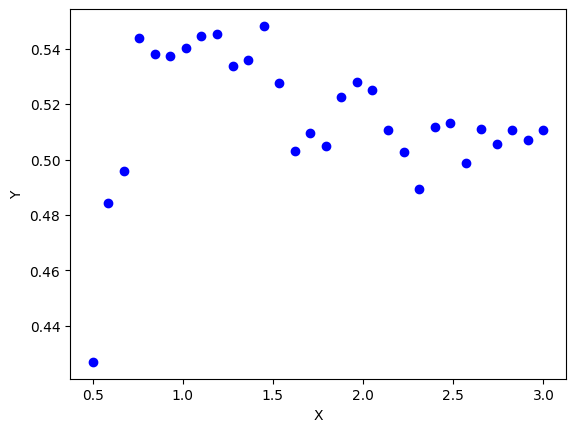

In [3]:
plt.plot(datay[:,0], datay[:,1], 'bo')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Least squares problem with QR factorization

In [4]:
x = datay[:,0]
yest = datay[:,1] #  given information
ytom = datay[:,2]  # tomorrow values

In [5]:
# We define some points in which we will evaluate the polynomial, and we set some variable used to plot the result
(nx,) = x.shape
xmin = min(x) 
xmax = max(x)
xx = np.linspace(xmin,xmax,200) # points used for evaluation

Define the Vandermonde matrix of order mp. So we look for a polynomial of degree mp-1 that better approximate the data. In this example we use mp = 5.
\begin{bmatrix}
1 & x_1 & x_1^2 &...& x_1^{mp-1}\\
1 & x_2 & x_2^2 &...& x_2^{mp-1}\\
. & . & . & ... &. \\
. & . & . & ... &. \\
1 & x_m & x_m^2 &...& x_m^{mp-1}\\
\end{bmatrix}

In [6]:
mp=5
A=np.vander(x,mp)
print('The shape of the Vandermonde matrix is', A.shape)

The shape of the Vandermonde matrix is (30, 5)


We solve the least-squares problem by first computing the QR factorization. The economic mode computes only the first mp column of Q. In many cases we are not able to solve the least-squares problem (we are not able to compute the complete QR factorization) if we don't use the economic setup. This because if the dataset is huge, than the matrix Q from the QR will be big. Anyway, in this example, we can also compute without economic because we have only fex data.
Now, we show step by step, how to solve the least-squares problem with the QR:
1) the problem to solve is $Ax = b$
2) compute the QR and we obtain $A = QR$ 
3) replace the factorization and we obtain $QRx = b$
4) since $Q$ is orthogonal, $Q^TQ = I$
5) compute $Q^TQRx = Q^Tb$, which is equal to $Rx = Q^Tb$
6) solve the linear system $Rx = Q^Tb$

In [7]:
(Q,R) = las.qr(A, mode='economic') # Compute the QR
p=las.solve(R, np.dot(np.transpose(Q),yest)) # solve the two linear systems 

We evaluate the polynomial in the point x, and we plot the results.

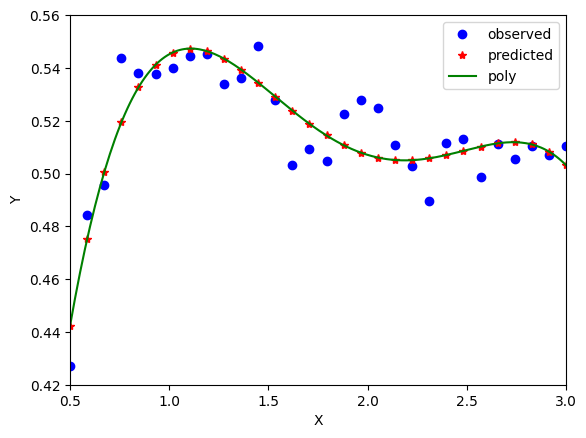

In [8]:
yr=np.polyval(p,x) # this evaluates in the point of our dataset
yc=np.polyval(p,xx) # this is used only to plot a shape of the function

plt.plot(x,yest,'bo', x,yr,'r*', xx,yc,'g-')
plt.axis([xmin,xmax,0.42,0.56])
plt.legend(['observed', 'predicted', 'poly'])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Add one row in the data and use a previously computed QR factorization to solve the Least squares problem
We want to simulate the case in which we have already computed the QR factorization and we have a new observation. We want to update our model with this new observation, but we don't want to recompute again all the factorization. We will use the givens rotation to update the already factorized elements with the new data point.<br>We start with $Ax = b$, we compute the QR and we obtain $Rx = Q^Tb$. So, we have 
$\begin{bmatrix}
\begin{bmatrix}
R\\
0
\end{bmatrix} & \begin{bmatrix}
Q_1^Tb\\
Q_2^Tb
\end{bmatrix}\\
\end{bmatrix}$ <br> Now we have a new row in our data
$\begin{bmatrix}
\begin{bmatrix}
R\\
0\\
\alpha
\end{bmatrix} & \begin{bmatrix}
Q_1^Tb\\
Q_2^Tb\\
\beta
\end{bmatrix}\\
\end{bmatrix}$
and we use the givens rotations to update the matrix and put zero on the last row. In the end we will obtain
 $\begin{bmatrix}
\begin{bmatrix}
\hat R\\
0
\end{bmatrix} & \begin{bmatrix}
\hat b_1\\
\hat \beta
\end{bmatrix}\\
\end{bmatrix}$ <br> and so the solution will be obtained solving $\hat R \hat x = \hat b_1$. <br>
<b>NB</b>: We don't explicitly compute the givens matrix and should never be done. We have all the information directly in the vectors.

In [9]:
BT = np.copy(A[0:6,:]) #We take only 6 rows, and we compute the QR on this data
yest_t = np.copy(yest[0:6])
(Qb,Rb) = las.qr(BT,mode='economic')
print('shape of the matrices','R =', Rb.shape,'BT=',BT.shape,'A=',A.shape)

shape of the matrices R = (5, 5) BT= (6, 5) A= (30, 5)


In [10]:
Qyest = np.dot(np.transpose(Qb),yest[0:6]) # Compute Qb^T * yest
pb=las.solve(Rb, Qyest) # Solve Rb * x = Qb^T * yest
print('Solution of the problem with all data (coefficients) ', p)
print('Solution of the problem (coefficients)', pb)

Solution of the problem with all data (coefficients)  [-0.04674372  0.37572645 -1.06865916  1.2389301   0.04592347]
Solution of the problem (coefficients) [ -8.58024134  24.32706842 -26.29007546  13.09187662  -2.04979986]


In [11]:
# Givens rotation to modify the QR factorization
at = np.copy(A[6,:])    # vector alpha (the new data)
bt = np.copy(yest[6])   # beta (the new data)
Rbt = np.copy(Rb)   # copy the matrix Rb to update

# For each row we use a givens rotation to multiply the correct row of R and the new data alpha
for j in range(mp):
    tv = np.copy(Rbt[j,:]) # we copy at each iteration a row
    den = np.sqrt(tv[j]**2.+at[j]**2.) # Givens rotation sqrt(x^2+y^2)
    cc = tv[j]/den # c element of the Givens matrix
    ss = at[j]/den # s element of the Givens matrix
    Rbt[j,:]=cc*tv+ss*at # we update the j-the row of the matrix
    at = -ss*tv+cc*at # we update the alpha-vector putting zero on j-position
    print('j=',j,'at=', at)
    
    # here we update also the right-side with the same operations
    btv = np.copy(Qyest[j])
    Qyest[j]= cc*btv+ss*bt
    bt  = -ss*btv+cc*bt

j= 0 at= [0.         0.12876434 0.28943505 0.49597953 0.77056032]
j= 1 at= [-0.          0.          0.03782934  0.14451848  0.37620624]
j= 2 at= [-0.00000000e+00  0.00000000e+00  3.46944695e-18 -1.22959379e-02
 -6.66268310e-02]
j= 3 at= [ 0.00000000e+00  0.00000000e+00 -2.16710433e-18  0.00000000e+00
 -3.38315950e-03]
j= 4 at= [ 0.00000000e+00  0.00000000e+00 -1.14167201e-18  0.00000000e+00
  2.16840434e-19]


In [12]:
#full factorization with qr_insert  
af = np.copy(A[6,:])
print(af.shape)
print(Rb.shape)
(Qf6,Rf6) = las.qr_insert(Qb, Rb, af, 5)

(5,)
(5, 5)


In [13]:
# full factorization with the last row added (so we recompute the QR with the new row)
B = np.copy(A[0:7,:]) 
yest_t = np.copy(yest[0:7]) 
(Qbt_6,Rbt_6)= las.qr(B, mode='economic')   
Qyest_6 = np.dot(np.transpose(Qbt_6), yest_t)
pbt=las.solve(Rbt_6, Qyest_6)

In [14]:
## Scaling the matrices for comparison because the QR is not unique in the sense that the sign 
## could be positive or negative. So we scale to compare the results. 
## The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0.
## Then we create a diagonal matrix with diagonal elements equals to the element 
## returned by the np.sign. Lastly, we compute np.dot to change the sign
## and make comparison. In the end, we will have the same sign in all the matrices.

# Here we scale the R matrix where the QR has been used on the matrix with the new point already inserted
D6 = np.sign(np.diag(Rbt_6)) 
Rbt_6 = np.dot(np.diag(D6), Rbt_6) 

# Here we scale the R matrix where the QR has been used on the original matrix 
# and then updated with the givens rotation for the new data point
D = np.sign(np.diag(Rbt))
Rbt = np.dot(np.diag(D) , Rbt)

# Here we scale the R matrix where the new point is inserted using the qr_insert method 
Df6 = np.sign(np.diag(Rf6)) 
Rft_6 = np.dot(np.diag(Df6), Rf6)

Qyest_6 = np.dot(np.diag(D6), Qyest_6)
Qyest = np.dot( np.diag(D), Qyest)

print('Comparison of the two factorization = ', np.linalg.norm(Rbt_6-Rbt,np.Inf))
print('Comparison of the two factorization = ', np.linalg.norm(Rbt_6-Rft_6,np.Inf ))
print('Comparison of the known term = ', np.linalg.norm(Qyest_6-Qyest))

Comparison of the two factorization =  2.7054085520619256e-15
Comparison of the two factorization =  2.321060010856968e-15
Comparison of the known term =  2.629744811621302e-15


## Least-square solution with scipy
lapack_driver = 'gelsd', 'gelsy', 'gelss'
1) <b>gelsd</b> stands for the Divide-and-Conquer Singular Value Decomposition (SVD) method: https://www.netlib.org/lapack/explore-html/d9/d67/group__gelsd.html
2) <b>gelsy</b> compute QR factorization with column pivoting: https://www.netlib.org/lapack/explore-html/dc/d8b/group__gelsy.html
3) <b>gelss</b> stands for the Least Squares via Singular Value Decomposition with Full Rank Triangular Factorization.
This method also employs singular value decomposition, but it uses a QR factorization with column pivoting and a special treatment of the singular values.https://www.netlib.org/lapack/explore-html/da/d55/group__gelss.html 

In [15]:
betaS, residualsS, rankS, svS = las.lstsq(A, yest) # Default lapack_driver='gelsd'
print ('beta:', betaS)
print ('residuals:', residualsS)
print ('rank:', rankS)
print ('singular values:', svS)

beta: [-0.04674372  0.37572645 -1.06865916  1.2389301   0.04592347]
residuals: 0.0033795680432563984
rank: 5
singular values: [1.82696080e+02 1.15074310e+01 2.73842395e+00 4.90013740e-01
 4.40419697e-02]


## Least square solution with pytorch
An open source machine learning framework that accelerates the path from research prototyping to production deployment. 
In this case driver chooses the LAPACK/MAGMA function that will be used. For CPU inputs the valid values are ‘gels’, ‘gelsy’, ‘gelsd', ‘gelss’. For CUDA input, the only valid driver is ‘gels’, which assumes that A is full-rank. https://pytorch.org/docs/stable/generated/torch.linalg.lstsq.html#torch.linalg.lstsq. <br>
If A is well-conditioned (its condition number is not too large), or you do not mind some precision loss:
* ‘gelsy’ for a general matrix (QR with pivoting) (default)
* ‘gels’ if A is full-rank (QR)

If A is not well-conditioned:
* ‘gelsd’ (tridiagonal reduction and SVD)
* ‘gelss’ if you run into memory issues full SVD).

In [16]:
# We define matrix / vector in torch called 'tensor', we can also specify the
# type. In this case we use the float64 bit to compare with scipy which use the 64bit.
AT = torch.tensor(A, dtype=torch.float64) 
bT = torch.tensor(yest, dtype=torch.float64)

X = torch.linalg.lstsq(AT, bT)
print('solution:',X.solution)
print('residuals between pytorch method and QR factorization:\n',torch.tensor(p)-X.solution)
print('rank:',X.rank)
print('residuals:',X.residuals)
print('singular values:', X.singular_values)

solution: tensor([-0.0467,  0.3757, -1.0687,  1.2389,  0.0459], dtype=torch.float64)
residuals between pytorch method and QR factorization:
 tensor([-6.9389e-16,  4.7184e-15, -1.1102e-14,  1.0880e-14, -3.9482e-15],
       dtype=torch.float64)
rank: tensor(5)
residuals: tensor([], dtype=torch.float64)
singular values: tensor([], dtype=torch.float64)


## Least square solution with tensorflow
https://www.tensorflow.org/api_docs/python/tf/linalg/lstsq

In [17]:
yest=yest.reshape(30,1)
ATF = tf.constant(A,dtype=tf.float64) # Creates a constant tensor from a tensor-like object.
bTF = tf.constant(yest,dtype=tf.float64)
XTF = tf.linalg.lstsq(ATF, bTF) # Solve the least-squares problem
print('Coefficients:\n',XTF)
print('tf.linalg.adjoint(XTF)-tf.constant(p)\n: ',tf.linalg.adjoint(XTF)-tf.constant(p))

Coefficients:
 tf.Tensor(
[[-0.04674372]
 [ 0.37572645]
 [-1.06865916]
 [ 1.2389301 ]
 [ 0.04592347]], shape=(5, 1), dtype=float64)
tf.linalg.adjoint(XTF)-tf.constant(p)
:  tf.Tensor(
[[-3.32255751e-12  2.36037301e-11 -5.81688031e-11  5.76163561e-11
  -1.87916835e-11]], shape=(1, 5), dtype=float64)


## Conditioning of least squares problems

### Compare the conditioning of the matrix $A$ and $A^TA$

In [18]:
A = np.array([(1, 1000), (0.00099, 1)])
print('Matrix A:\n',A)

Matrix A:
 [[1.0e+00 1.0e+03]
 [9.9e-04 1.0e+00]]


In [19]:
# condition number of A and A^T*A
ATA = A.T.dot(A)
print ('Condition number of  A:', np.linalg.cond(A))
print ('Condition number of  A^T*A:', np.linalg.cond(ATA))
print('We can check that the condition number of A^T*A is square respect to the condition number of A.\n'
      'If we solve the system with A^T*A maybe we won\'t have significant digits. \n'
      'If we are able to solve using A we will have at least 7/8 significant digits.')

Condition number of  A: 100000200.00009844
Condition number of  A^T*A: 1.0011603907636136e+16
We can check that the condition number of A^T*A is square respect to the condition number of A.
If we solve the system with A^T*A maybe we won't have significant digits. 
If we are able to solve using A we will have at least 7/8 significant digits.


### Comparison of conditioning with two collinear predictors 

In [20]:
tmp = np.arange(100)
A = np.zeros((100, 2))
A[:, 0] = tmp + np.random.rand(100) * 0.00000001
A[:, 1] = tmp + np.random.rand(100) * 0.00000001
ATA = A.T.dot(A)
print ('Condition number of A^T*A  for the simulating data :', np.linalg.cond(ATA))
print ('Condition number of A for the simulating data :',np.linalg.cond(A))

Condition number of A^T*A  for the simulating data : 1.5955185829106714e+16
Condition number of A for the simulating data : 29016835274.59291


### Example: matrix B with one column almost linear combination of the column of A (where the third column has general noise)

In [21]:
A=np.array([[1, 0],[1, 1],[1, 1]])
B=np.zeros((3,3))
B[:,0:2]=A
B[:,2:3]= np.dot(A, np.array([[1],[0.5]]))+1e-7*np.random.randn(3,1)

print('Matrix B:\n',B)

Matrix B:
 [[1.         0.         1.        ]
 [1.         1.         1.49999994]
 [1.         1.         1.50000006]]


In [22]:
# we introduce a random error, and we compute b as B times a vector of all 1 + an error
xt = np.array([[1],[1],[1]]) 
b=np.dot(B,xt)+1e-6*np.random.randn(3,1)

x = las.solve(B, b) # the matrix is non-singular so we can solve the system 
print('solution of the square linear system:\n', x)

resn = np.linalg.norm(B.dot(x)-b,2)/np.linalg.norm(b,2) 
print('\nresidual',resn)

condB= np.linalg.cond(B) 
print('condition number of B:',condB )

# the error is bounded by
print('the error is bounded by', condB*resn/np.linalg.norm(b))

print('\nwe can check that the results is wrong but the residuals is very small. \n'
      'This because we are computing the exactly solution since the matrix is non singular.'
      '\nThe problem is that the matrix is non singular since we add noise.'
      '\nSo, the noise is detected more than the original structure of the matrix.')

solution of the square linear system:
 [[11.28982554]
 [ 6.14491437]
 [-9.28982617]]

residual 2.0376207893330041e-16
condition number of B: 58454260.02772102
the error is bounded by 2.2310897797098232e-09

we can check that the results is wrong but the residuals is very small. 
This because we are computing the exactly solution since the matrix is non singular.
The problem is that the matrix is non singular since we add noise.
So, the noise is detected more than the original structure of the matrix.


If we try to solve this problem using the SVD, nothing change. We obtain exactly the same results because the matrix is non-singular. So, exists only one solution. Since we have applied the SVD we can check the singular values.
Check that the third singular value makes the matrix non-singular, but it is very small respect to the first two.
So, the first two components are related to the original matrix. We can approximate the matrix using only the first two components. In that case the matrix won't be non-singular, and so the solution will be given by the minimum norm solution.

In [23]:
betaS, residualsS, rankS, svS = las.lstsq(B, b,lapack_driver='gelsd')
print ( 'beta:')
print(betaS)
print ('residuals:', residualsS)
print ('rank:', rankS)
print ('singular values:', svS)

beta:
[[11.28982555]
 [ 6.14491437]
 [-9.28982618]]
residuals: []
rank: 3
singular values: [3.17054304e+00 6.69071612e-01 5.42397259e-08]


Also using pytorch, we obtain exactly the same results and singular values.

In [24]:
BT = torch.tensor(B,dtype=torch.float64)
bT = torch.tensor(b,dtype=torch.float64)
print(BT.shape)
Xb = torch.linalg.lstsq(BT, bT,driver='gelsd')
print(Xb.solution)
print(Xb.rank)
print(Xb.residuals)
print(Xb.singular_values)

torch.Size([3, 3])
tensor([[11.2898],
        [ 6.1449],
        [-9.2898]], dtype=torch.float64)
tensor(3)
tensor([], dtype=torch.float64)
tensor([3.1705e+00, 6.6907e-01, 5.4240e-08], dtype=torch.float64)


Since we know that only the first two singular values are big and the last is very small and related to the noise, we compute the SVD. Then, we take only the first two singular values and we compute an approximate solution. The numerical rank could be considered as two. Since we know the Eckart-Young theorem, we know also the residuals which is exactly equal to $\sigma_{k+1}$. In this case equal to the third singualar value.

In [25]:
U, s, V = np.linalg.svd(B, full_matrices=False)

# Solution computed with the pseudo-inverse of the matrix A_2
xT = np.dot(V[0:2,:].T,(np.dot( b.T, U[:,0:2])/s[0:2]).T) 

# the residual is small,has the same order of the error in the data, the data have a better meaning
resn = np.linalg.norm(B.dot(xT)-b,2)/np.linalg.norm(b,2) 
print('approximated solution:\n', xT)
print('residuals: ', resn)

approximated solution:
 [[0.77777718]
 [0.88889013]
 [1.22222224]]
residuals:  1.6020409531742464e-07
